## 4. Modeling

En la etapa de modelado, se procede a entrenar diversos modelos utilizando técnicas de validación cruzada y ajuste de hiperparámetros. El objetivo es encontrar el modelo más adecuado que pueda realizar predicciones precisas sobre la variable objetivo.

Además, durante esta etapa se analiza la importancia relativa de las características (features) en el proceso de predicción. Este análisis permite identificar qué características tienen un mayor impacto en las predicciones del modelo y puede ayudar a mejorar la comprensión del problema y la interpretación de los resultados.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.core.interactiveshell import InteractiveShell
from utils.model_io  import dump_pickle

warnings.filterwarnings('ignore')

habi_df = pd.read_parquet('./data/prepared/habi_feature.parquet')

In [2]:
habi_df.is_selected.value_counts()

is_selected
0    1299
1     897
Name: count, dtype: int64


### Oversampling

El oversampling es útil en este caso porque nuestro dataset presenta un desequilibrio entre las clases de la variable "is_selected". Esto significa que hay una cantidad significativamente mayor de ejemplos en una clase en comparación con la otra.

Esto es beneficioso para el modelado porque evita el sesgo hacia la clase mayoritaria y permite que el modelo aprenda de manera más efectiva las características y patrones de ambas clases

In [3]:
habi_df = habi_df.sample(frac=1,random_state=5).reset_index(drop=True)

is_selected_df = habi_df.loc[habi_df['is_selected'] == 1]
non_selected_df = habi_df.loc[habi_df['is_selected'] == 0][:897]

normal_distributed_df = pd.concat([is_selected_df, non_selected_df])

# Shuffle dataframe 
habi_df = normal_distributed_df.sample(frac=1, random_state=42)

habi_df.shape

(1794, 23)

### Distribucion variable objetivo vs variables categoricas

In [4]:
binary_cols = ['terms_conditions','is_tax_return','viability','has_region_id','has_date_exp_token']
ohe_cols = ['type_independent_activity_id','region_id','activity','job_role','year_exp_token','year_birth','age_section','month_exp_token']
numerical_cols = ['incomes','extra_incomes','familiar_debts',] #'age'
categorical = binary_cols+ ohe_cols
target ='is_selected'


terms_conditions


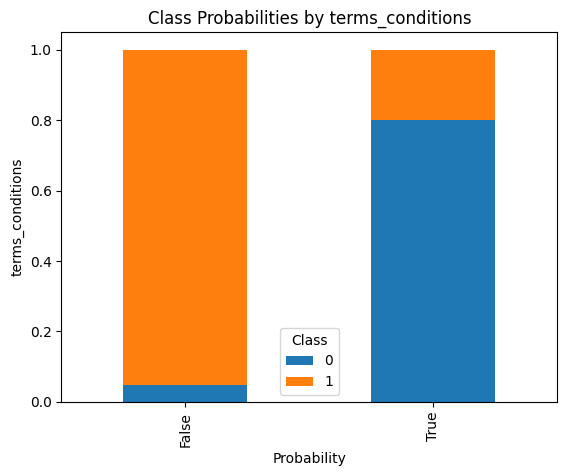

is_tax_return


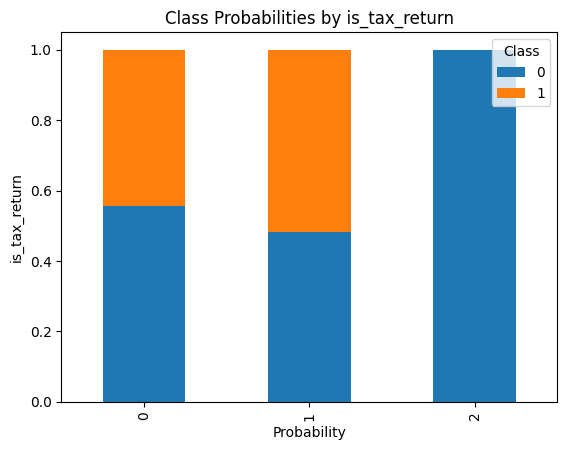

viability


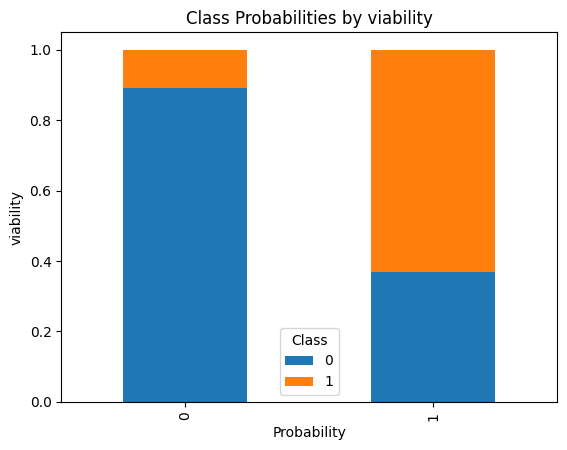

has_region_id


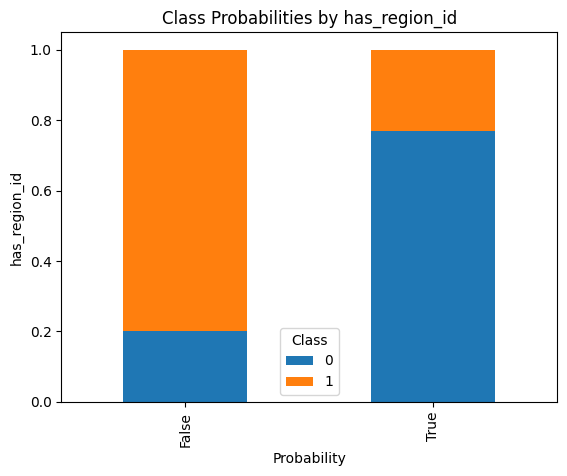

has_date_exp_token


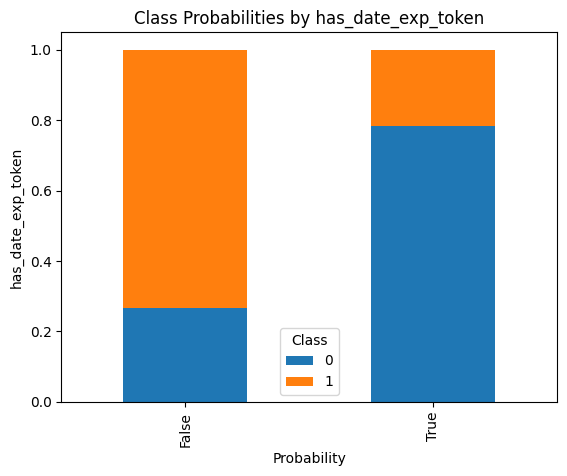

type_independent_activity_id


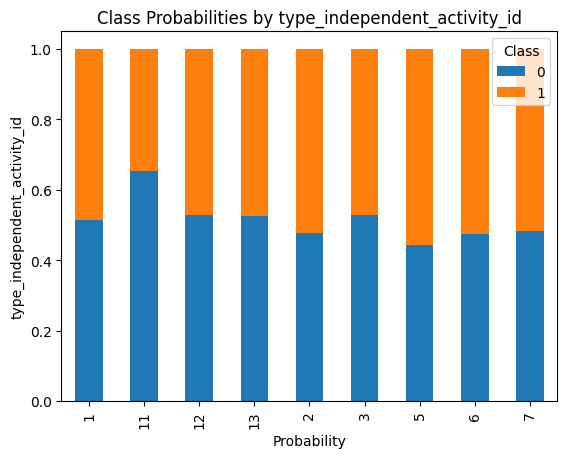

region_id


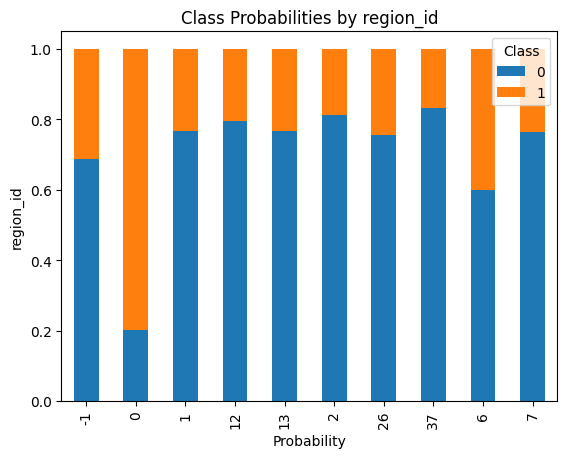

activity


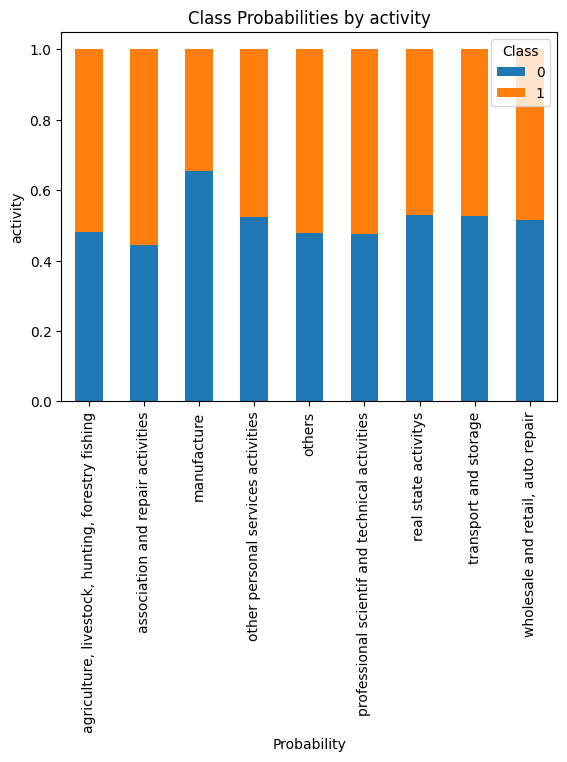

job_role


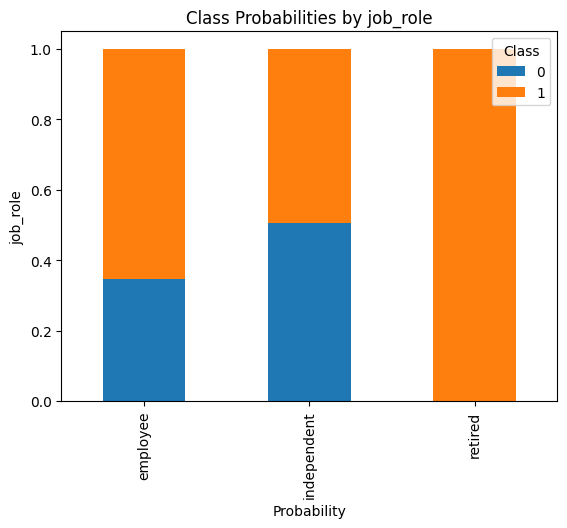

year_exp_token


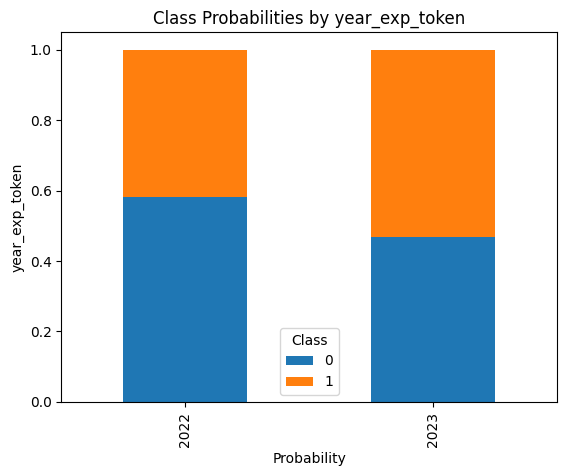

year_birth


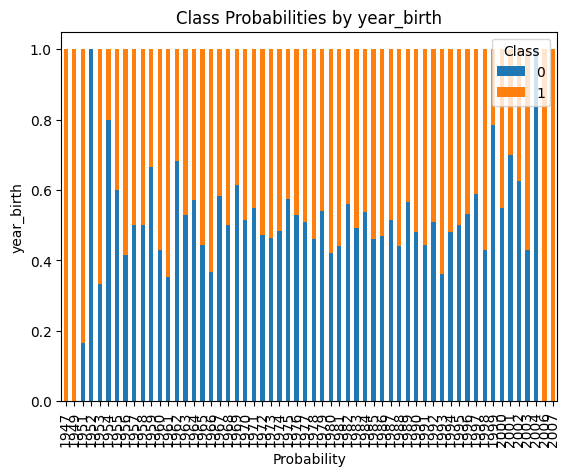

age_section


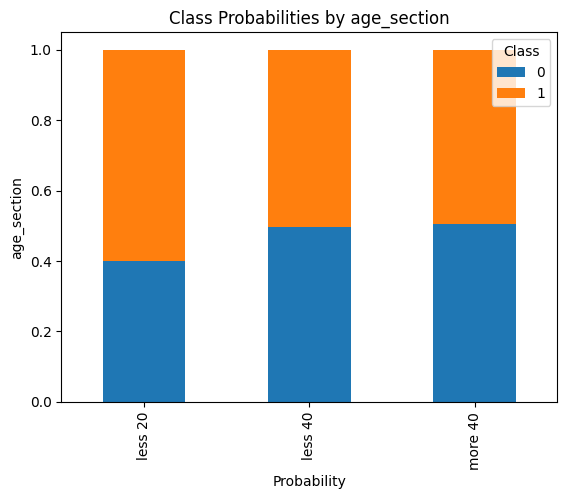

month_exp_token


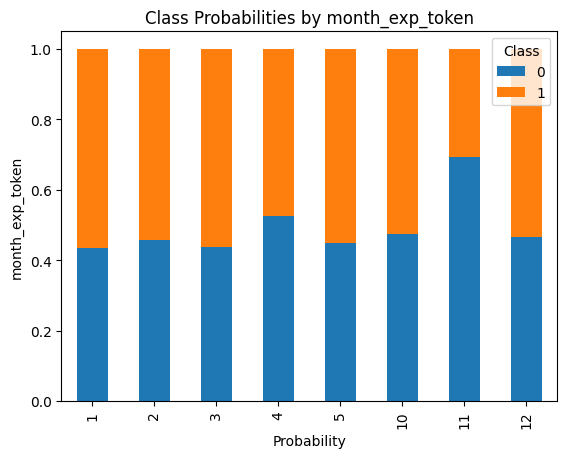

In [5]:
def proba_plot(df:pd.DataFrame,feature:str):
    # Calculate probabilities
    class_counts = df.groupby([feature, target]).size().unstack()
    class_probs = class_counts.div(class_counts.sum(axis=1), axis=0)

    # Plotting
    class_probs.plot(kind='bar', stacked=True)
    plt.xlabel('Probability')
    plt.ylabel(feature)
    plt.title(f'Class Probabilities by {feature}')
    plt.legend(title='Class')
    plt.show()
    

for c in categorical:
    print(c)
    proba_plot(habi_df,c)

* En general las variables parecen aportar informacion importante a nuestro ejercio, las variables que menos contribuyen apotar informacion son age_section y job_role y month_exp_token. 

# Feature importance

In [6]:
from sklearn.metrics import mutual_info_score

def mutual_info_churn_score(series):
    return mutual_info_score(series,habi_df['is_selected'])


mi = habi_df[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

terms_conditions                0.316854
region_id                       0.172348
has_region_id                   0.170821
has_date_exp_token              0.138989
viability                       0.114513
month_exp_token                 0.014344
year_birth                      0.013634
year_exp_token                  0.005189
type_independent_activity_id    0.002541
activity                        0.002541
is_tax_return                   0.002406
job_role                        0.001827
age_section                     0.000136
dtype: float64

* El feature importance corrobora nuestra informacion acerca de age_section y job_role, para nuestro caso month_exp_token parece aportar informacion pero creo que el valor del mes (month_exp_token) es mas un valor aleatorio que no debe estar correlacionado con el target, asi que no lo tomare en adelante.

### One-Hot-Encoding

En la fase de One-Hot-Encoding aplicare esta tecnica a todas las variables categoricas. En este caso, se ha decidido conservar las variables binarias en su forma original, sin ningún cambio.

En cuanto a las variables categóricas restantes, se les aplicará el método de One-Hot-Encoding utilizando un DictVectorizer. Al utilizar un DictVectorizer, se logrará una mayor facilidad para el despliegue de modelos en la API.

In [7]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer



ohe_cols = ['type_independent_activity_id','is_tax_return','region_id','activity','job_role','year_exp_token','age_section']
binary_cols = ['terms_conditions','viability','has_extra_incomes', 'has_familiar_debts', 'has_region_id', 'has_date_exp_token']
numerical_cols = ['incomes','extra_incomes','familiar_debts']

all_cols = ohe_cols+binary_cols+numerical_cols

X, y = habi_df[all_cols].reset_index(drop=True), habi_df['is_selected'].reset_index(drop=True)


data_dict = X.to_dict(orient='records')

# Create an instance of DictVectorizer and fit-transform the data
vectorizer = DictVectorizer(sparse=False)
encoded_features = vectorizer.fit_transform(data_dict)

dump_pickle(vectorizer,'./artifacts/dict_vectorizer_is_selected.pkl')

X_encoded_df = pd.DataFrame(encoded_features, columns=vectorizer.get_feature_names_out())


In [8]:
X.to_dict(orient='records')[0]

{'type_independent_activity_id': '6',
 'is_tax_return': 1,
 'region_id': '0',
 'activity': 'professional scientif and technical activities',
 'job_role': 'independent',
 'year_exp_token': '2023',
 'age_section': 'less 40',
 'terms_conditions': True,
 'viability': 1,
 'has_extra_incomes': 1,
 'has_familiar_debts': 1,
 'has_region_id': False,
 'has_date_exp_token': False,
 'incomes': 16.52356082573315,
 'extra_incomes': 0.0,
 'familiar_debts': 0.0}

In [9]:
X.columns

Index(['type_independent_activity_id', 'is_tax_return', 'region_id',
       'activity', 'job_role', 'year_exp_token', 'age_section',
       'terms_conditions', 'viability', 'has_extra_incomes',
       'has_familiar_debts', 'has_region_id', 'has_date_exp_token', 'incomes',
       'extra_incomes', 'familiar_debts'],
      dtype='object')

### Entrenamiento del modelo (Entrenamiento, Test, Validacion)

Durante la fase de entrenamiento del modelo, se llevará a cabo la división de los datos en conjuntos de entrenamiento, prueba y validación. Para garantizar una evaluación confiable del rendimiento del modelo, se utilizará la técnica de StratifiedKFold.

El 20% de los datos se reservará para el conjunto de prueba, que se utilizará para evaluar el rendimiento final del modelo en datos no vistos previamente. Los datos restantes, que representan el 80% del conjunto de datos original, se utilizarán para entrenar y validar el modelo.

Para evaluar el modelo, se utilizará la métrica F1-score. Esta métrica es una medida armonizada entre la precisión y la exhaustividad (recall), y es especialmente útil cuando se busca equilibrar la clasificación de las clases, considerando tanto los falsos positivos como los falsos negativos.

In [10]:
from sklearn.model_selection import train_test_split,StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y,test_size=0.2, random_state=6, stratify=y)


In [11]:
from sklearn.metrics import f1_score
import optuna
from sklearn.metrics import confusion_matrix, classification_report

class ModelTrainer:
    def __init__(self, search_space, model, n_trials=10, n_jobs=8, cv=2):
        self.search_space = search_space
        self.model = model
        self.n_trials = n_trials
        self.n_jobs = n_jobs
        self.cv = cv
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.best_model = None
        
    def fit_data(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def evaluate_model(self, trial, x_train, y_train, x_val, y_val):
        params = self.search_space(trial)
    
        # Create the classifier
        classifier = self.model(**params)
        
        # Fit the classifier
        classifier.fit(x_train, y_train)
        
        # Make predictions
        preds = classifier.predict(x_val)
        
        # Calculate evaluation metrics
        score = f1_score(y_val, preds, average='weighted')
        
        return score
    
    def evaluate_cv(self, trial):        
        skf = StratifiedKFold(n_splits=self.cv)
        score_list = []
        
        for train_index, test_index in skf.split(self.X_train, self.y_train):
            x_train_fold, x_val_fold = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
            y_train_fold, y_val_fold = self.y_train.iloc[train_index], self.y_train.iloc[test_index]
            score = self.evaluate_model(trial, x_train_fold, y_train_fold, x_val_fold, y_val_fold)
            score_list.append(score)
        
        return np.mean(score_list)
    
    def optimize_model(self):
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='maximize')

        # Optimize the objective function
        study.optimize(self.evaluate_cv, n_trials=self.n_trials, n_jobs=self.n_jobs)
        best_params = study.best_params
        best_score = study.best_value

        self.best_classifier = self.model(**best_params)
        self.best_classifier.fit(self.X_train, self.y_train)
        
        return best_params, best_score,self.best_classifier
    
    
class MetricPlots():
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = self.model.predict(self.X_test)
        self.labels = np.unique(self.y_test)
        
    def confusion_matrix(self):
        labels = [0,1]
        cm = confusion_matrix(self.y_test, self.y_pred,labels=labels)
        cm_df = pd.DataFrame(cm ,columns=labels,index=labels)
        plt.figure(figsize=(8, 8))
        plot =sns.heatmap(cm_df,cmap="PuBuGn",annot=True,fmt='g')
        plot.set(xlabel='Predicted', ylabel='Actual')
        
    def classification_report(self):
        print(classification_report(self.y_test, self.y_pred, labels=self.labels))

        


### Espacio de hiperparametros

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

def SearchSpace():    
    def XGBClassifier(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'booster': 'gbtree',
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1),
            'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.9, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
        }    
        return params
    
    def LogisticRegression(trial):
        params = {
            'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
            'C': trial.suggest_loguniform('C', 0.001, 100.0),
            'solver': trial.suggest_categorical('solver', [ 'liblinear', 'saga']),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
            'max_iter': trial.suggest_int('max_iter', 100, 10000),
            'random_state': 42
        }
        return params
    
    def SVC(trial):
        params = {
            'C': trial.suggest_loguniform('C', 0.001, 100.0),
            'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
            'degree': trial.suggest_int('degree', 1, 5),
            'random_state': 42,
            'probability':trial.suggest_categorical('probability', [True])
        }
        return params
    
    def MLPClassifier(trial):
        hidden_layer_sizes_choices = [
            (10,),
            (20,),
            (30,),
            (40,),
            (10, 10),
            (20, 20),
            (40, 40),
            (10, 20),
            (10,10,10)
        ]   
        
        params = {
            'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes',  hidden_layer_sizes_choices),
            'activation': trial.suggest_categorical('activation', ['logistic', 'tanh', 'relu']),
            #'learning_rate': trial.suggest_categorical('learning_rate', ['invscaling', 'adaptive']),
            'alpha':trial.suggest_loguniform('alpha', 1e-5, 1e-1),
            'random_state': 42
        }
        
        return params
    
    return dict(XGBClassifier=XGBClassifier,
                LogisticRegression=LogisticRegression,
                SVC=SVC,
                MLPClassifier=MLPClassifier)




## 5.0 Evaluacion

Durante la evaluación de los modelos, utilizaremos cuatro algoritmos de clasificación diferentes: XGBClassifier, LogisticRegression, SVC y MLPClassifier. Para cada modelo, ajustaremos y optimizaremos sus hiperparámetros utilizando la técnica de validación cruzada con 5 folds.

Además, utilizaremos Optuna para buscar los mejores hiperparámetros para cada modelo. Optuna es una biblioteca de optimización automatizada que nos ayudará a encontrar la combinación óptima de hiperparámetros para maximizar el rendimiento del modelo.

In [13]:
model_params = SearchSpace()

# Model list for hyperparameter tuning
cv_models = [
    (xgb.XGBClassifier,model_params['XGBClassifier'],'XGBClassifier'),
    (LogisticRegression,model_params['LogisticRegression'],'LogisticRegression'),
    (SVC,model_params['SVC'],'SVC'),
    (MLPClassifier,model_params['MLPClassifier'],'MLPClassifier')
]

best_models = {}

for model, params, name in cv_models:
    model_trainer= ModelTrainer(params,model,n_trials=15,cv=5,n_jobs=-1)    
    model_trainer.fit_data(X_train,y_train,X_test,y_test)    
    best_params, best_score, best_model = model_trainer.optimize_model()
    best_models[name] = best_model
    print(f'----------MODEL: {name} ----------')
    print(f'Best score {best_score:.4f}' )
    print(f'params =  {best_params}' )
    print(f'CLASSIFICATION METRICS')
    print(f'')
    mp = MetricPlots(best_model,X_test,y_test)
    mp.classification_report()
    print(f'\n')
    



----------MODEL: XGBClassifier ----------
Best score 0.8687
params =  {'max_depth': 8, 'learning_rate': 0.06363268567431812, 'subsample': 0.8, 'colsample_bytree': 0.6, 'n_estimators': 148, 'gamma': 0.6978316274603996, 'reg_alpha': 7.345289958131734, 'reg_lambda': 4.699599996643499}
CLASSIFICATION METRICS

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       180
           1       0.93      0.78      0.85       179

    accuracy                           0.86       359
   macro avg       0.87      0.86      0.86       359
weighted avg       0.87      0.86      0.86       359



----------MODEL: LogisticRegression ----------
Best score 0.8683
params =  {'penalty': 'l1', 'C': 0.18587311710638713, 'solver': 'saga', 'fit_intercept': False, 'max_iter': 8370}
CLASSIFICATION METRICS

              precision    recall  f1-score   support

           0       0.83      0.91      0.86       180
           1       0.90      0.81      0.85       17

* Curva ROC comparativa de los modelos

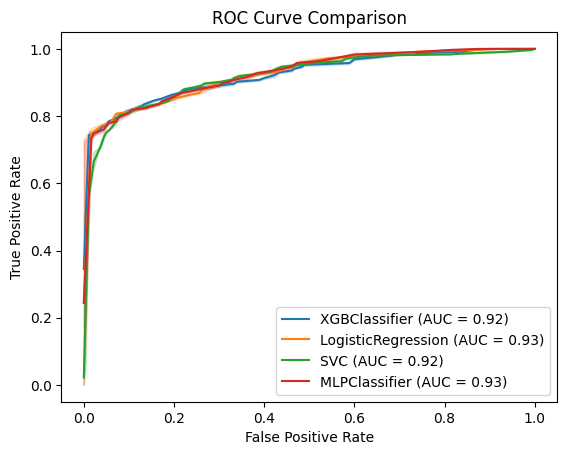

In [ ]:
import seaborn as sns
from sklearn import metrics

# Create an empty figure and axis object
fig, ax = plt.subplots()

# Iterate over the models
for name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.auc(fpr, tpr)
    sns.lineplot(x=fpr,y= tpr, ax=ax, label=f'{name} (AUC = {auc:.2f})')

# Set labels for the plot
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Comparison')

# Display the plot
plt.show()

* Curva Precision-Recall comparativa de los modelos

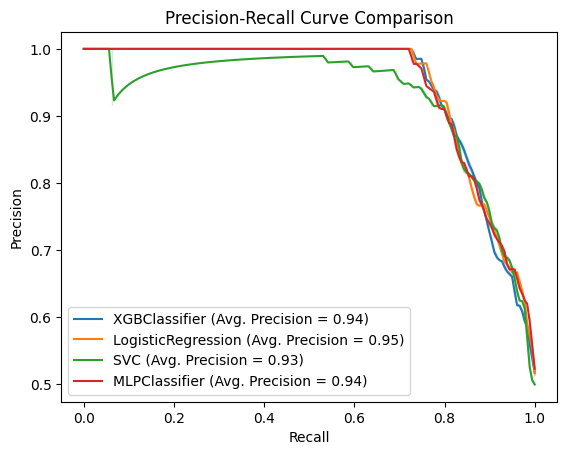

In [ ]:
import seaborn as sns
from sklearn import metrics

# Create an empty figure and axis object
fig, ax = plt.subplots()

# Iterate over the models
for name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    average_precision = metrics.average_precision_score(y_test, y_pred_proba)
    sns.lineplot(x=recall, y=precision, ax=ax, label=f'{name} (Avg. Precision = {average_precision:.2f})')

# Set labels for the plot
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve Comparison')
ax.legend()

# Display the plot
plt.show()

## 6) Despliegue

En la etapa de despliegue, guardaremos los mejores modelos entrenados en archivos pickle. Estos archivos contienen los modelos y sus parámetros optimizados, lo que nos permite cargarlos fácilmente en una API 

In [22]:

for name, model in best_models.items():
    print('Saving = ',name)
    dump_pickle(model,f'./models/{name}_is_selected.pkl')
    

Saving =  XGBClassifier
Saving =  LogisticRegression
Saving =  SVC
Saving =  MLPClassifier
